In [14]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sb
from matplotlib.pylab import rcParams
from matplotlib import rc
import os
import glob
import pickle
import pandas as pd

In [2]:
# GRAPHICS SETUP:
rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=False)
fontSize=16
sb.set_style('dark')
rcParams['ytick.labelsize'] = fontSize
rcParams['xtick.labelsize'] = fontSize
%matplotlib inline

In [4]:
def GetDataDicts(fp):
    with nc.Dataset(fp) as ds:
        l3bVars = ds.groups['level-3_binned_data'].variables
        binlist = l3bVars['BinList'][:]
        wts = binlist['weights']
        bands = ['412', '443', '490', '510', '555', '670', '765', '865']
        rhoDict = {}
        rhoUncDict = {}
        rhotDict = {} 
        for band in bands:
            rhoDict[band] = np.pi * l3bVars['Rrs_%s' % band][:]['sum'] / wts
            rhoUncDict[band] = np.pi * l3bVars['Rrs_unc_%s' % band][:]['sum'] / wts
            rhotDict[band] = l3bVars['rhot_%s' % band][:]['sum'] / wts
    return rhoDict,rhoUncDict,rhotDict

In [5]:
def GetPtileDict(dataDict,ptile=.95,bands=['412','443','490',
                                          '510','555','670']):
    dataPtileDict = dict.fromkeys(bands)
    for band in bands:
        sortedData = np.sort(dataDict[band])
        dataPtileDict[band] = sortedData[int(np.floor(sortedData.size * ptile))]
    return dataPtileDict

In [36]:
def SummaryPlot(df,**kwargs):
    ptile = kwargs.pop("ptile",0.95)
    bands = kwargs.pop("bands",['412','443','490','510','555','670'])
    colors= kwargs.pop("colors",['black','brown','blue','m','c','r'])
    savepath = kwargs.pop('savepath',None)
    title = kwargs.pop('title',None)
    f,ax=pl.subplots(figsize=(12,7))
    axYmaxBase = kwargs.pop('ymaxBase',0.002)
    axYmax = kwargs.pop('ymax',axYmaxBase)
    axInYmax = 2.1e-4
    ax.set_ylim(0,axYmax)
    gboxY = 8e-5 / axYmax
    gboxY2 = 8e-5 / axInYmax
    ymaxScl = axYmaxBase / axYmax
    ax.set_xlim(412,700)
    ax.set_xticks([412,443,490,510,555,670])
    if title:
        ax.set_title(title,fontsize=22)
    ax.set_ylabel(r'uncertainty ($\rho$)',fontsize=17)
    ax.set_xlabel(r'$\lambda$',fontsize=18)
    ax.axvspan(412,600,ymin=0,ymax=.5*ymaxScl,facecolor='gray',alpha=0.1)
    ax.axvspan(412,600,ymax=.4*ymaxScl,
               facecolor='gray',alpha=0.3)
    ax.axvspan(600,700,ymax=1 * ymaxScl,
               facecolor='gray',alpha=0.1,label='threshold')
    ax.axvspan(600,700,ymax=.8 * ymaxScl,facecolor='gray',alpha=0.3,label='20% margin')
    ax.axvspan(650,700,ymax=gboxY,facecolor='gold',alpha=0.4,label='nflh ROI')
    expList = df.columns.tolist()
    for exp,col in zip(expList,colors): 
        lbl = '%s' % exp
        ax.plot(df[exp],label=lbl,marker='o',color=col,lw=1.5)
    ax.ticklabel_format(style='sci',axis='y',scilimits=(-2,3))
    ax.legend(loc='best',fontsize=18)#bbox_to_anchor=(1.05,.75),fontsize=18);
    if savepath:
        fmt = savepath.split('.')[-1] if '.' in savepath else 'png'
        f.savefig(savepath,dpi=300,format = fmt)

In [8]:
mainDir='/Users/grayWolf/DEVEL/UNC_notebooks/DATA'
filePattern = 'S20031932003196.L3b_4D*'
fileList = glob.glob(os.path.join(mainDir,filePattern))
snrs = ['NIR_SNR_' + str(k) for k in range(500,850,50)]
simDict = dict.fromkeys(snrs)
for file in fileList:
    sfx = int(file.split('.')[1][-2:])
    snr = (sfx - 27) * 50 + 500
    snr = 'NIR_SNR_' + str(snr)
    simDict[snr] = file

In [9]:
simDict

{'NIR_SNR_500': '/Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU27.nc',
 'NIR_SNR_550': '/Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU28.nc',
 'NIR_SNR_600': '/Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU29.nc',
 'NIR_SNR_650': '/Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU30.nc',
 'NIR_SNR_700': '/Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU31.nc',
 'NIR_SNR_750': None,
 'NIR_SNR_800': '/Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU33.nc'}

In [13]:
rhoUnc95Dict = dict.fromkeys(snrs)
for snr in snrs:
    # Get data needed in form of a dict.
    if simDict[snr]:
        print('processing %s' % simDict[snr])
        _,rhoUncDict,_ = GetDataDicts(fp=simDict[snr])
        # Fill out 95 ptile dictionary for corresponding snr sim - result is a nested dictionary with
        # bands as keys to the internal dict
        rhoUnc95Dict[snr] = GetPtileDict(rhoUncDict) 
pickle.dump(rhoUnc95Dict,open('snr_vvv1500_nirSens.p','wb'))

processing /Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU27.nc
processing /Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU28.nc
processing /Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU29.nc
processing /Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU30.nc
processing /Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU31.nc
processing /Users/grayWolf/DEVEL/UNC_notebooks/DATA/S20031932003196.L3b_4D_SU33.nc


In [17]:
df95 = pd.DataFrame(rhoUnc95Dict)

In [22]:
df95.dropna(axis=1,how='all',inplace=True)

In [24]:
df95.to_pickle('df_snr_vvv1500_nirSens.p')

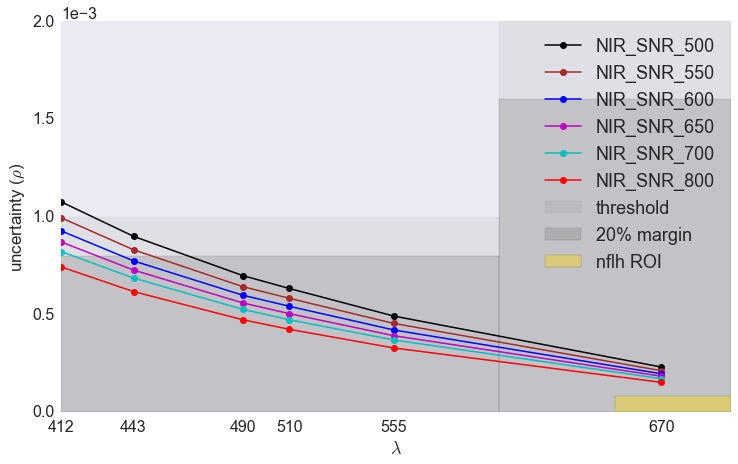

In [37]:
SummaryPlot(df95,savepath='snrSens_vvv1500nir500_800.png')